In [27]:
# Flow_from_directory
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.regularizers import L2
import pandas as pd


In [2]:
IMAGE_SIZE = 224

# Test data
test_generator = ImageDataGenerator(rescale=1./255)
test = test_generator.flow_from_directory('data/full/calc/test/', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=16, class_mode='binary')

Found 36 images belonging to 2 classes.
Found 7 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [28]:
# load model
model = load_model('model.h5')

<Figure size 432x288 with 0 Axes>

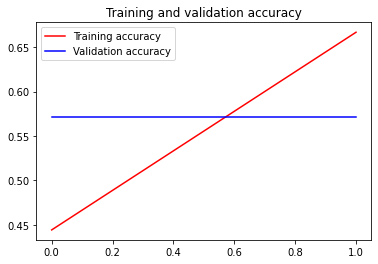

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

1/1 [==============================] - 4s 4s/step


Text(0, 0.5, 'True positive rate')

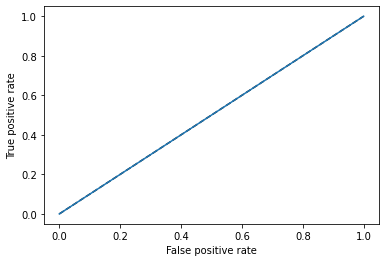

In [7]:
# Create roc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Get the predictions from the model using the generator
predictions = model.predict(test)

# Get the true values from the generator
true_values = test.classes

# Get the predicted probabilities for each class
pred_probabilities = predictions

# Get the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(true_values, pred_probabilities)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ResNet152')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

### Recall, percission and accuracy

In [23]:
# helper funcitons
def get_recall_i(conf_mat, i):
    """
    Computes.
    """
    return conf_mat[i, i] / np.sum(conf_mat[:, i])


def get_all_recalls(conf_mat):
    """
    Computes All recalls
    """

    return [get_recall_i(conf_mat, i) for i in range(conf_mat.shape[0])]


def get_percision_i(conf_mat, i):
    """
    Computes.
    """
    return conf_mat[i, i] / np.sum(conf_mat[i, :])


def get_all_percisions(conf_mat):
    """
    Computes all percisions.
    """

    return [get_percision_i(conf_mat, i) for i in range(conf_mat.shape[0])]


def get_overall_accuracy(conf_mat):
    """
    Computes the overall accuracy of the given confusion matrix.
    """
    return np.trace(conf_mat) / np.sum(conf_mat)

def get_confusion_matrix(result):
    result["Rounded"] = result["Prediction"].round()
    
    # creates confusion matrix
    true_positive_fake = result[(result['Filename'].str.contains(
        'benign')) & (result['Rounded'] == 0)].count()[0]
    false_positive_fake = result[(result['Filename'].str.contains(
        'malignant')) & (result['Rounded'] == 0)].count()[0]

    true_positive_real = result[(result['Filename'].str.contains(
        'malignant')) & (result['Rounded'] == 1)].count()[0]
    false_positive_real = result[(result['Filename'].str.contains(
        'benign')) & (result['Rounded'] == 1)].count()[0]

    conf_matrix = np.matrix([
        [true_positive_fake, false_positive_fake],
        [false_positive_real, true_positive_real]
    ])
    
    return conf_matrix

In [8]:
# predictions and evaluation
pred_res = model.predict(
            test,
            verbose=1)

1/1 [==============================] - 2s 2s/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [19]:
test_results = pd.DataFrame({
                "Filename": test.filenames,
                "Prediction": pred_res.flatten()
            })
test_results.head()

,Filename,Prediction
0,benign\1.3.6.1.4.1.9590.100.1.2.22805321931175...,0.0
1,benign\1.3.6.1.4.1.9590.100.1.2.29045701201249...,0.0
2,benign\1.3.6.1.4.1.9590.100.1.2.68605716126292...,0.0
3,malignant\1.3.6.1.4.1.9590.100.1.2.25518783621...,0.0
4,malignant\1.3.6.1.4.1.9590.100.1.2.41938323721...,0.0


In [24]:
conf_matrix = get_confusion_matrix(test_results)
print("conf_matrix: \n", conf_matrix)
print("Recalls:", np.round(get_all_recalls(conf_matrix), 3))
print("Precisions:", np.round(get_all_percisions(conf_matrix), 3))
print("Accurcy:", np.round(get_overall_accuracy(conf_matrix), 3))

conf_matrix: 
 [[3 3]
 [0 0]]
Recalls: [1. 0.]
Precisions: [0.5 nan]
Accurcy: 0.5


C:\Users\henriks\AppData\Local\Temp/ipykernel_48572/4246959766.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
  return conf_mat[i, i] / np.sum(conf_mat[i, :])
